In [1]:
#get packages and directory
import scanpy as sc
import seaborn as sns
import numpy as np
import anndata as ad
import scvi
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import biomart
directory = '/Users/david/Dropbox/RNASeq/Rat'

/Users/david/opt/anaconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/Users/david/opt/anaconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (


In [2]:
#get ribosomal genes
ribo_url = "http://software.broadinstitute.org/gsea/msigdb/download_geneset.jsp?geneSetName=WP_CYTOPLASMIC_RIBOSOMAL_PROTEINS&fileType=txt"
ribo_genes = pd.read_table(ribo_url, skiprows=2, header = None)

In [3]:
#pre-processing function for each batch
def preprocess(matrix_path,name):
    adata = sc.read_10x_h5(matrix_path)   
    adata.obs['Sample'] = name
    sc.pp.filter_cells(adata, min_counts = 1000)
    sc.pp.filter_cells(adata, max_counts = 40000)
    adata.var['mt'] = adata.var_names.str.startswith('Mt-')  # annotate the group of mitochondrial genes as 'mt'
    adata.var['ribo'] = adata.var_names.str.lower().isin(ribo_genes[0].str.lower())
    sc.pp.calculate_qc_metrics(adata, qc_vars=['mt', 'ribo'], percent_top=None, log1p=False, inplace=True)
    adata = adata[adata.obs.pct_counts_mt < 10]
    adata = adata[adata.obs.pct_counts_ribo < 4]
    adata.var_names_make_unique()
    adata.obs.index=adata.obs['Sample'].to_numpy() + ":" + np.array(adata.obs.index)

    return adata

In [4]:
#perform pre-processing
#N1 and N2 are NAc batches, V1 and V2 are VP batches
names = ['N1','N2','V1','V2']
files = ['N1_filtered_matrix.h5','N2_filtered_matrix.h5','V1_filtered_matrix.h5','V2_filtered_matrix.h5']
out = []
for x in range(0,4):
    out.append(preprocess(directory + '/Matrices/' + files[x],names[x]))

/Users/david/opt/anaconda3/envs/scvi-env/lib/python3.9/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/david/opt/anaconda3/envs/scvi-env/lib/python3.9/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/david/opt/anaconda3/envs/scvi-env/lib/python3.9/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/david/opt/anaconda3/envs/scvi-env/lib/python3.9/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/david/opt/anaconda3/envs/scvi-env/lib/python3.9/site-packages

In [5]:
#combine all batches
adata = sc.concat(out)
sc.pp.filter_genes(adata, min_cells = 1) #get rid of genes with no counts
adata.X.shape

(50095, 23149)

In [6]:
#convert to sparse matrix
from scipy.sparse import csr_matrix
adata.X = csr_matrix(adata.X)

In [9]:
adata.layers['counts'] = adata.X.copy() #save a raw counts version

In [7]:
adata.write_h5ad(directory + '/combined.h5ad')

In [8]:
adata = sc.read_h5ad(directory + '/combined.h5ad')
adata.obs.index

Index(['N1:AAACCCAAGACGCAGT-1', 'N1:AAACCCAAGCGAATGC-1',
       'N1:AAACCCAAGGACAACC-1', 'N1:AAACCCAAGGTAAACT-1',
       'N1:AAACCCAAGTCGTCTA-1', 'N1:AAACCCACACATACGT-1',
       'N1:AAACCCACACCAAAGG-1', 'N1:AAACCCACACCTGAAT-1',
       'N1:AAACCCACAGGACATG-1', 'N1:AAACCCACAGTATACC-1',
       ...
       'V2:TTTGTTGCATCGGCCA-1', 'V2:TTTGTTGGTAGTGATA-1',
       'V2:TTTGTTGGTAGTTCCA-1', 'V2:TTTGTTGGTTCGGCGT-1',
       'V2:TTTGTTGGTTCGGCTG-1', 'V2:TTTGTTGGTTGCATTG-1',
       'V2:TTTGTTGTCATTGTTC-1', 'V2:TTTGTTGTCCACTGGG-1',
       'V2:TTTGTTGTCCGTATAG-1', 'V2:TTTGTTGTCCGTGTCT-1'],
      dtype='object', length=50095)

In [10]:
#get highly variable genes for gene expression similarity analysis
sc.pp.highly_variable_genes(adata, n_top_genes = 2000, subset = True, layer='counts', flavor = 'seurat_v3', batch_key='Sample')
adata.X.shape

(50095, 2000)

In [11]:
#setup scVI model
scvi.model.SCVI.setup_anndata(adata, layer = 'counts',
                             batch_key='Sample')
model = scvi.model.SCVI(adata)

/Users/david/opt/anaconda3/envs/scvi-env/lib/python3.9/abc.py:119: FutureWarning: SparseDataset is deprecated and will be removed in late 2024. It has been replaced by the public classes CSRDataset and CSCDataset.

For instance checks, use `isinstance(X, (anndata.experimental.CSRDataset, anndata.experimental.CSCDataset))` instead.

For creation, use `anndata.experimental.sparse_dataset(X)` instead.

  return _abc_instancecheck(cls, instance)


In [12]:
model.train()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 1/160:   0%|                                                                              | 0/160 [00:00<?, ?it/s]

/Users/david/opt/anaconda3/envs/scvi-env/lib/python3.9/abc.py:119: FutureWarning: SparseDataset is deprecated and will be removed in late 2024. It has been replaced by the public classes CSRDataset and CSCDataset.

For instance checks, use `isinstance(X, (anndata.experimental.CSRDataset, anndata.experimental.CSCDataset))` instead.

For creation, use `anndata.experimental.sparse_dataset(X)` instead.

  return _abc_instancecheck(cls, instance)


Epoch 160/160: 100%|██████████████| 160/160 [17:02<00:00,  6.22s/it, v_num=1, train_loss_step=756, train_loss_epoch=851]

`Trainer.fit` stopped: `max_epochs=160` reached.


Epoch 160/160: 100%|██████████████| 160/160 [17:02<00:00,  6.39s/it, v_num=1, train_loss_step=756, train_loss_epoch=851]


In [13]:
#save latent variables
adata.obsm['X_scVI'] = model.get_latent_representation()

In [ ]:
#doublet detection function
def doubdetect(name):
    solo_batch = scvi.external.SOLO.from_scvi_model(model, restrict_to_batch=name)
    solo_batch.train()
    bp = solo_batch.predict()
    return bp

In [ ]:
#perform doublet detection
names = ['N1','N2','V1','V2']
out = []
for x in range(0,4):
    out.append(doubdetect(names[x]))

In [ ]:
#identify doublet barcodes
dps = pd.concat(out,axis=0)
dps['isdoublet']=dps['doublet']>dps['singlet']

In [19]:
#remove doublets
adata=adata[dps['isdoublet']==False]
adata.X.shape

(43378, 2000)

In [20]:
adata.write_h5ad(directory + '/integrated.h5ad')

In [8]:
adata = sc.read_h5ad(directory + '/combined.h5ad')
adata_scvi = sc.read_h5ad(directory + '/integrated.h5ad')

In [ ]:
#remove doublets and save latent variables to original matrix (with all genes)
barcodes_inc = adata_scvi.obs.index
adata = adata[adata.obs.index.isin(barcodes_inc)]
adata.obsm['X_scVI'] = adata_scvi.obsm['X_scVI']

In [11]:
adata.X.shape

(43378, 23149)

In [13]:
#calculate nearest neighbors
sc.pp.neighbors(adata, use_rep = 'X_scVI', n_neighbors = 50)

/Users/david/opt/anaconda3/envs/scvi-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(


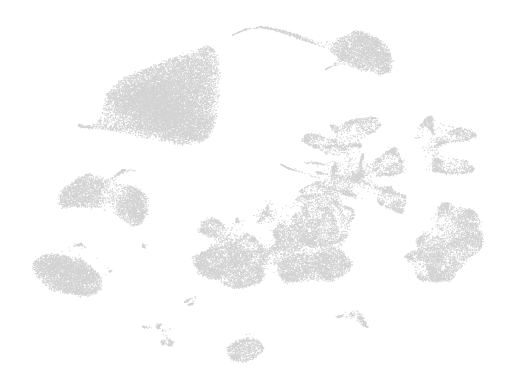

In [14]:
#calculate UMAP
sc.tl.umap(adata, min_dist=0.5)
sc.pl.umap(adata, frameon = False)

/Users/david/opt/anaconda3/envs/scvi-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/david/opt/anaconda3/envs/scvi-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


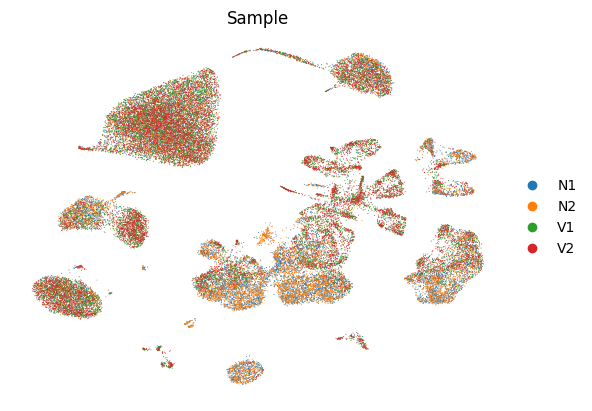

In [15]:
kwargs = {'alpha': 1}
sc.pl.umap(adata, color = ['Sample'], size = 2, frameon = False, **kwargs)

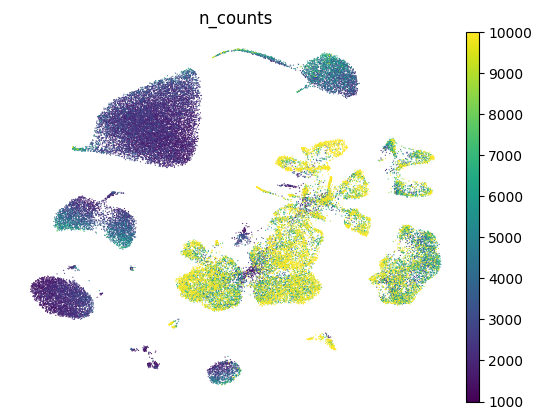

In [16]:
sc.pl.umap(adata, color = ['n_counts'], frameon = False, vmax = 10000)

In [19]:
#cluster for cell-typing
sc.tl.leiden(adata, resolution = 0.1)

/Users/david/opt/anaconda3/envs/scvi-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/david/opt/anaconda3/envs/scvi-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


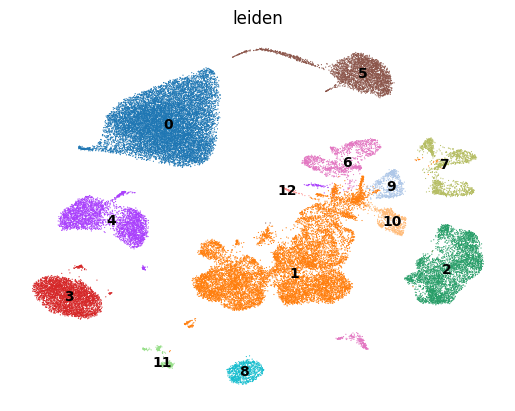

In [25]:
sc.pl.umap(adata, color = ['leiden'], frameon = False, legend_loc = 'on data')

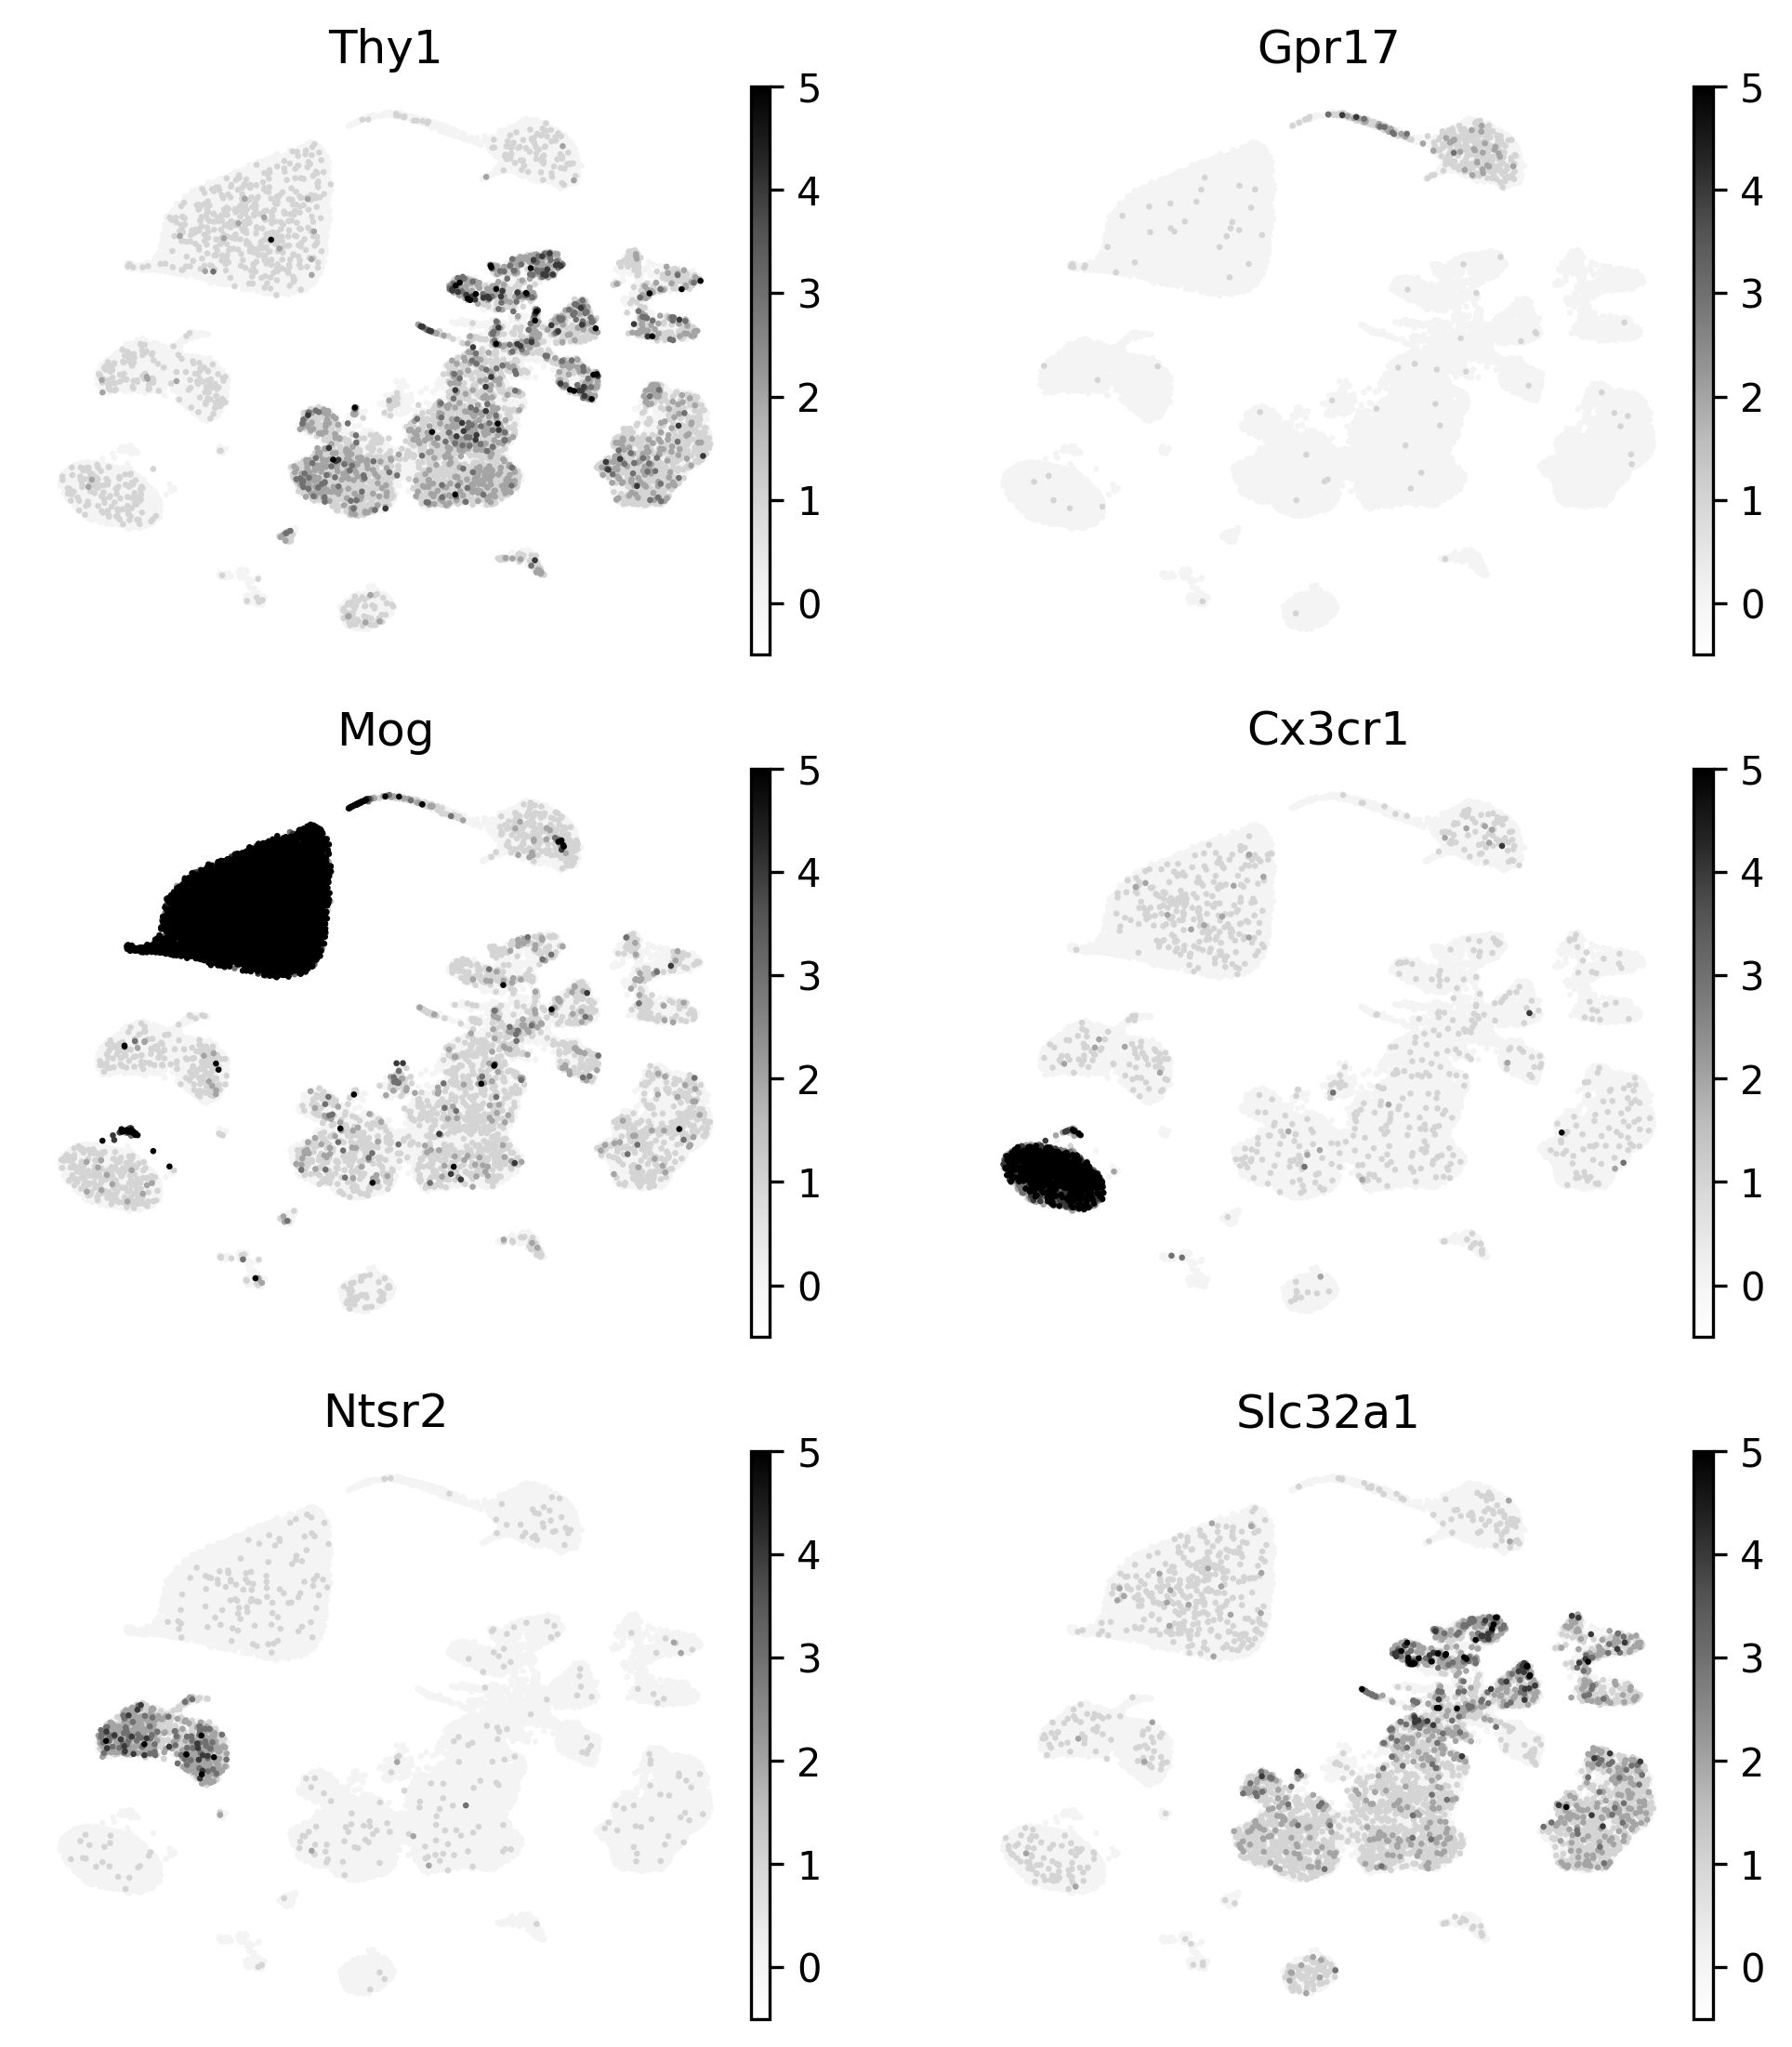

In [37]:
plt.figure(figsize = (8,9))
um = plt.subplot(3,2,1)
um = sc.pl.umap(adata, color = ['Thy1'], frameon = False,
                size=10, ax = um, layer = 'counts', vmin=-0.5, vmax=5,
                cmap='Grays',show=False)
um = plt.subplot(3,2,2)
um = sc.pl.umap(adata, color = ['Gpr17'], frameon = False,
                size=10, ax = um, layer = 'counts', vmin=-0.5, vmax=5,
                cmap='Grays',show=False)
um = plt.subplot(3,2,3)
um = sc.pl.umap(adata, color = ['Mog'], frameon = False,
                size=10, ax = um, layer = 'counts', vmin=-0.5, vmax=5,
                cmap='Grays',show=False)
um = plt.subplot(3,2,4)
um = sc.pl.umap(adata, color = ['Cx3cr1'], frameon = False,
                size=10, ax = um, layer = 'counts', vmin=-0.5, vmax=5,
                cmap='Grays',show=False)
um = plt.subplot(3,2,5)
um = sc.pl.umap(adata, color = ['Ntsr2'], frameon = False,
                size=10, ax = um, layer = 'counts', vmin=-0.5, vmax=5,
                cmap='Grays',show=False)
um = plt.subplot(3,2,6)
um = sc.pl.umap(adata, color = ['Slc32a1'], frameon = False,
                size=10, ax = um, layer = 'counts', vmin=-0.5, vmax=5,
                cmap='Grays',show=False)
plt.savefig(directory + '/Figures/cellsExpression.png')

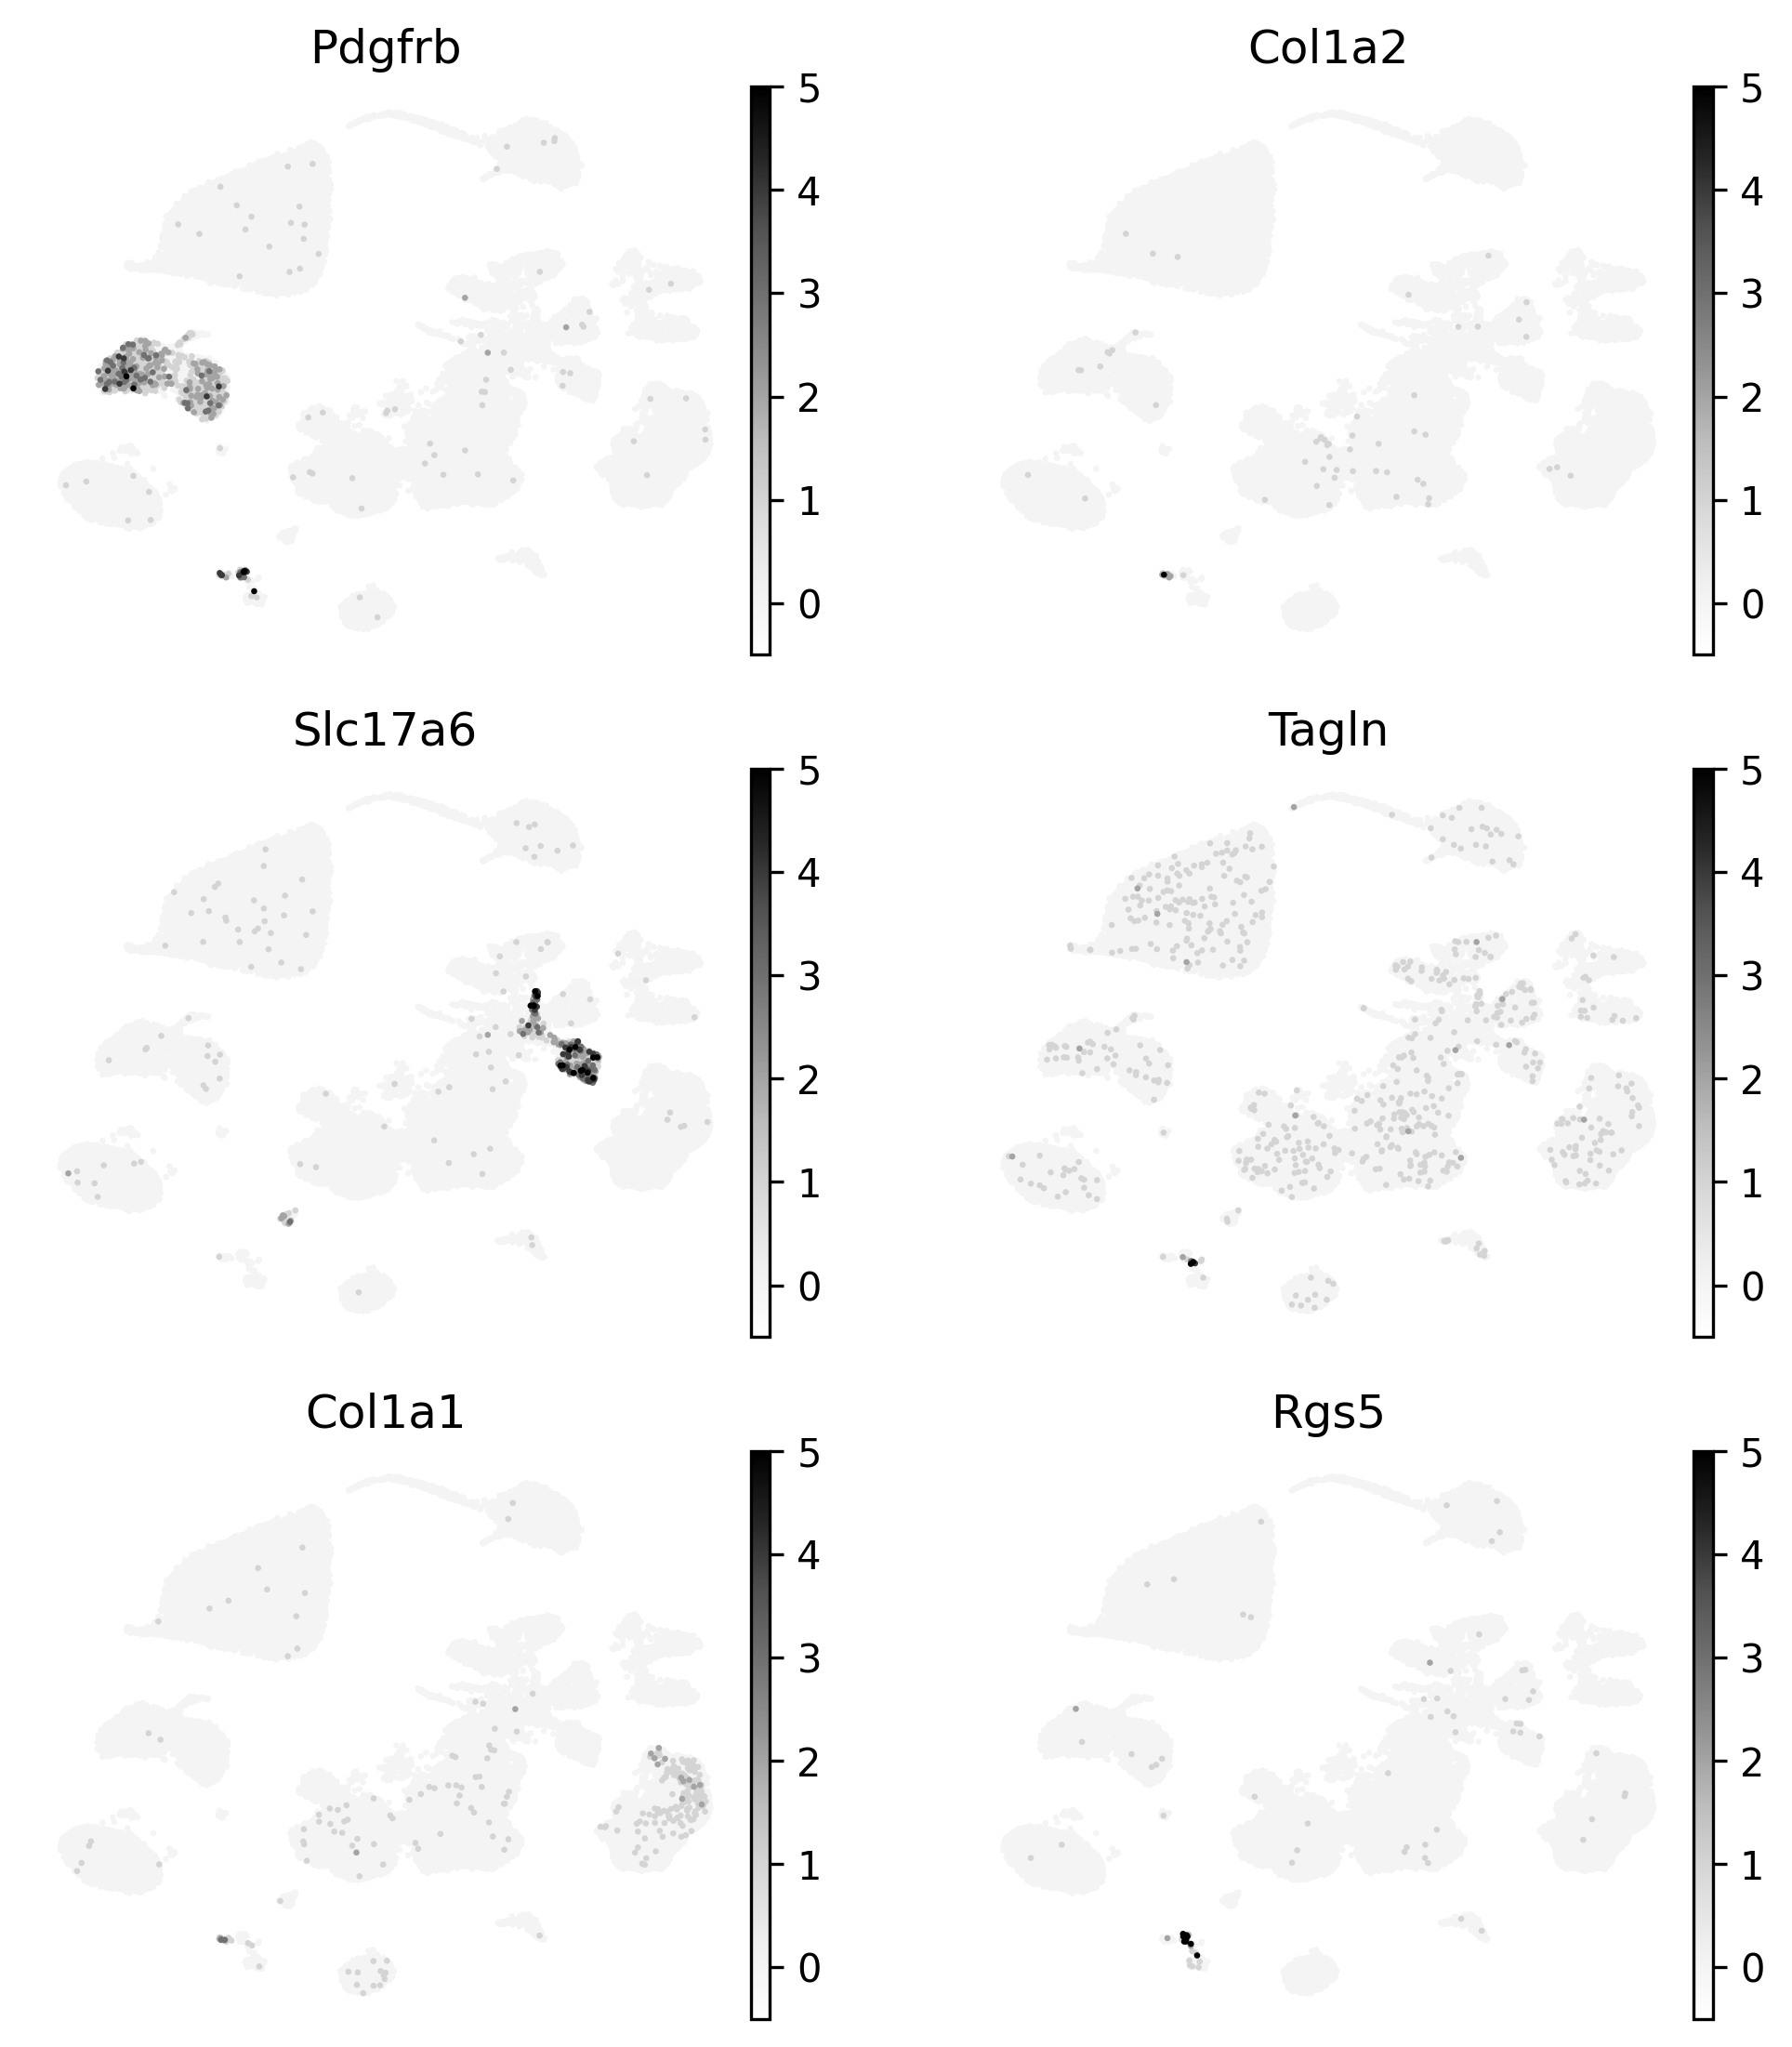

In [38]:
plt.figure(figsize = (8,9))
um = plt.subplot(3,2,1)

#pericyte
um = sc.pl.umap(adata, color = ['Pdgfrb'], frameon = False,
                size=10, ax = um, layer = 'counts', vmin=-0.5, vmax=5,
                cmap='Grays',show=False)
um = plt.subplot(3,2,2)

#fibroblast
um = sc.pl.umap(adata, color = ['Col1a2'], frameon = False,
                size=10, ax = um, layer = 'counts', vmin=-0.5, vmax=5,
                cmap='Grays',show=False)
um = plt.subplot(3,2,3)


um = sc.pl.umap(adata, color = ['Slc17a6'], frameon = False,
                size=10, ax = um, layer = 'counts', vmin=-0.5, vmax=5,
                cmap='Grays',show=False)
um = plt.subplot(3,2,4)
um = sc.pl.umap(adata, color = ['Tagln'], frameon = False,
                size=10, ax = um, layer = 'counts', vmin=-0.5, vmax=5,
                cmap='Grays',show=False)
um = plt.subplot(3,2,5)
um = sc.pl.umap(adata, color = ['Col1a1'], frameon = False,
                size=10, ax = um, layer = 'counts', vmin=-0.5, vmax=5,
                cmap='Grays',show=False)
um = plt.subplot(3,2,6)
um = sc.pl.umap(adata, color = ['Rgs5'], frameon = False,
                size=10, ax = um, layer = 'counts', vmin=-0.5, vmax=5,
                cmap='Grays',show=False)
plt.savefig(directory + '/Figures/cellsExpression2.png')

In [31]:
cell_type = {"0":"Oligodendrocytes",
             "1":"Neurons",
"2":"Neurons",
"3":"Microglia",
"4":"Astrocytes",
"5":"Oligo. precursor cells",
"6":"Neurons",
"7":"Neurons",
"8":"Neurons",
"9":"Neurons",
"10":"Neurons",
"11":"Fibr./Pericyte", 
"12":"Neurons", 
}

adata.obs['celltype'] = adata.obs.leiden.map(cell_type)

In [32]:
ctcolors = {"Neurons":(0.71, 0.88, 0.54),
            "Oligodendrocytes":(0.86, 0.52, 0.83),
            "Astrocytes":(0.58, 0.73, 0.94),
            "Oligo. precursor cells":(0.97, 0.62, 0.62),
            "Microglia":(0.97, 0.8, 0.55),
            "Fibr./Pericyte":(0.97, 0.93, 0.68),
           }

In [33]:
plt.rcParams['figure.dpi'] = 300

/Users/david/opt/anaconda3/envs/scvi-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/david/opt/anaconda3/envs/scvi-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


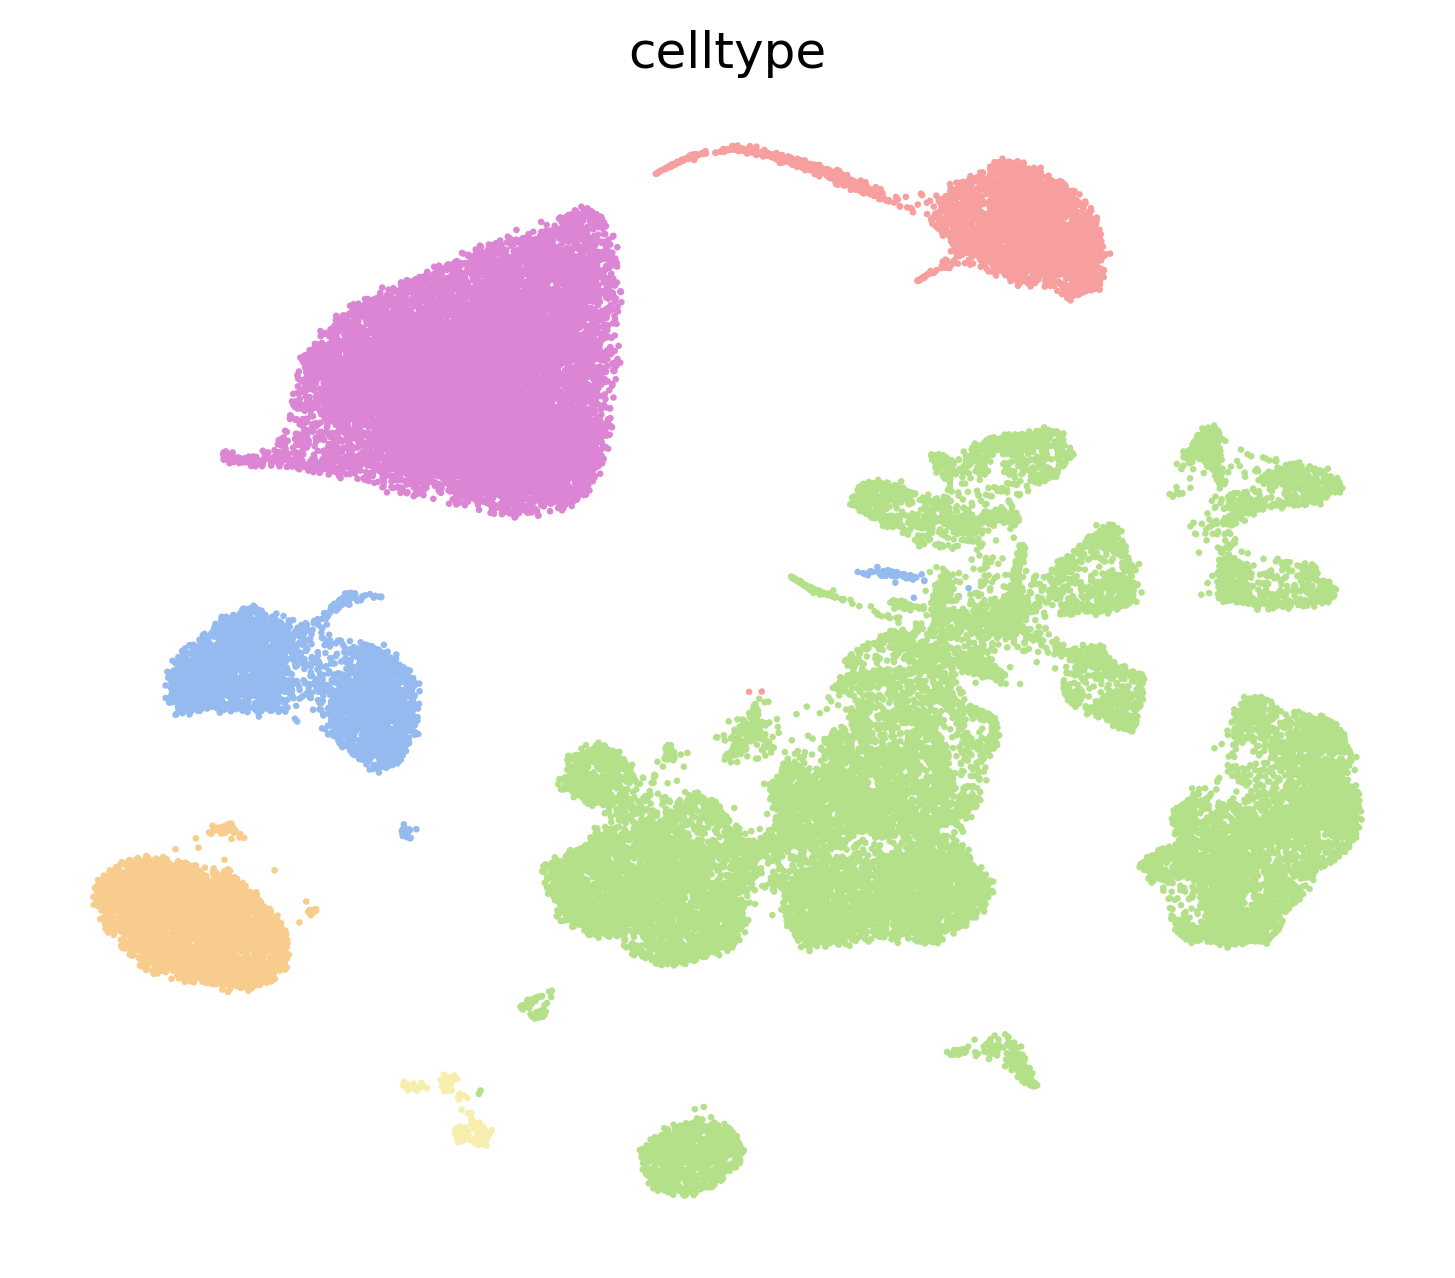

In [34]:
plt.figure(figsize = (6,5))
um = plt.subplot(1,1,1)
um = sc.pl.umap(adata, color = ['celltype'], frameon = False, size=10, ax = um, palette = ctcolors, show=False, legend_loc='off right')
plt.savefig(directory + '/Figures/cellsUMAP.png')

In [35]:
ctcolorsN = {"Neurons":(0.71, 0.88, 0.54),
            "Oligodendrocytes":(0.8, 0.8, 0.8),
            "Astrocytes":(0.8, 0.8, 0.8),
            "Oligo. precursor cells":(0.8, 0.8, 0.8),
            "Microglia":(0.8, 0.8, 0.8),
            "Fibr./Pericyte":(0.8, 0.8, 0.8),
           }

/Users/david/opt/anaconda3/envs/scvi-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(


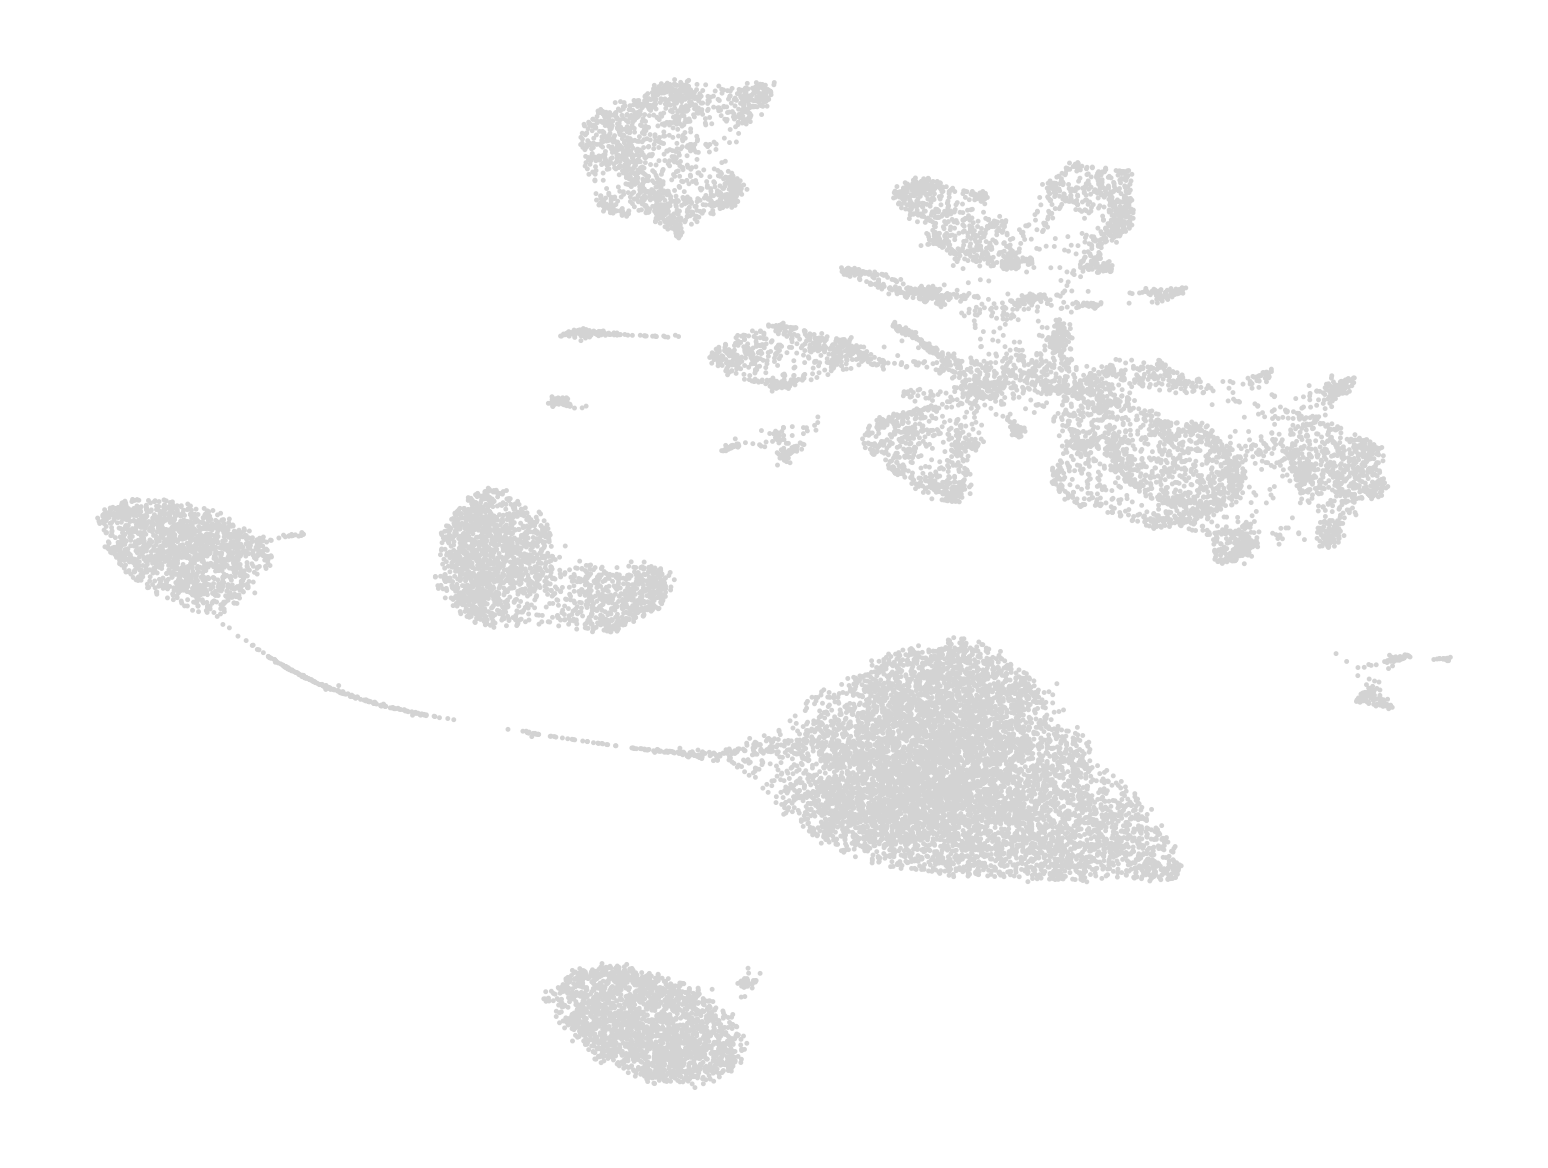

In [72]:
#redo UMAP for only VP dissections
adataVP = adata[adata.obs['Sample'].isin(['V1','V2'])].copy()
sc.pp.neighbors(adataVP, use_rep = 'X_scVI', n_neighbors = 50)
sc.tl.umap(adataVP, min_dist=0.5)
sc.pl.umap(adataVP, frameon = False)

/Users/david/opt/anaconda3/envs/scvi-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/david/opt/anaconda3/envs/scvi-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


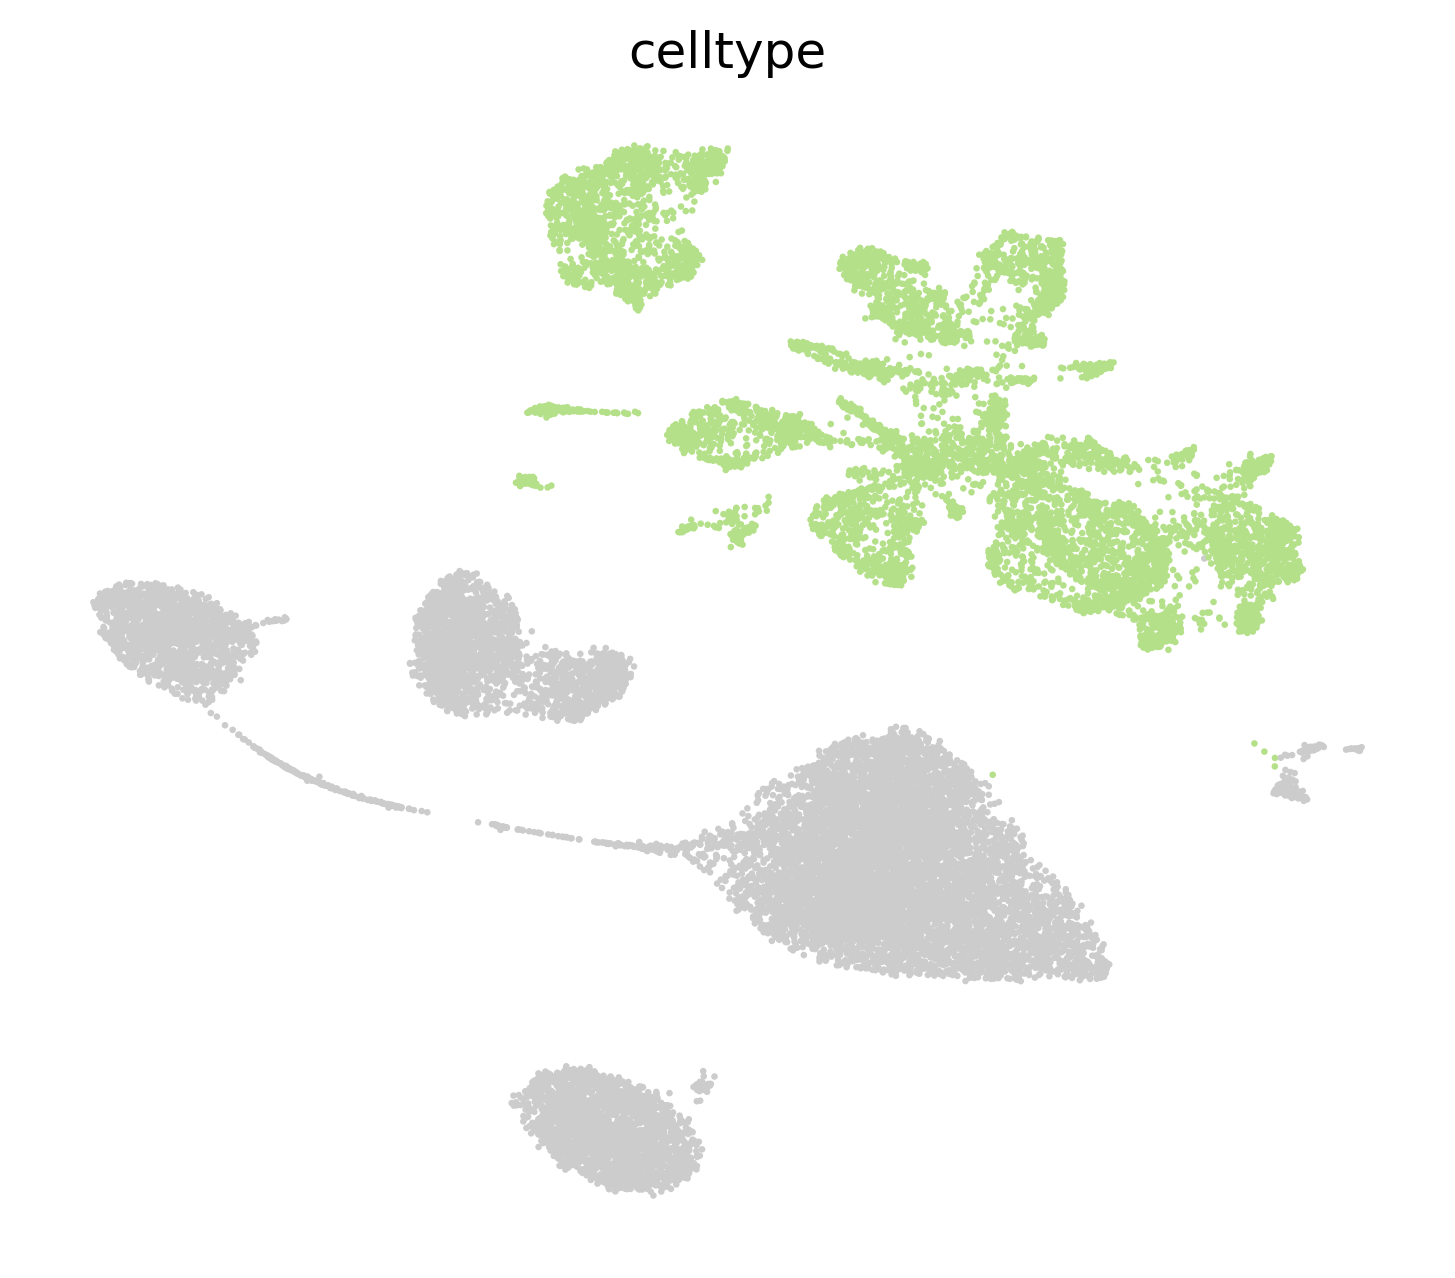

In [73]:
plt.figure(figsize = (6,5))
um = plt.subplot(1,1,1)
um = sc.pl.umap(adataVP, color = ['celltype'], frameon = False, size=10, ax = um, palette = ctcolorsN, show=False, legend_loc='off right')
plt.savefig(directory + '/Figures/cellsUMAPNVP.png')

In [39]:
#color by batch
gpcolors = {"N1":np.divide((106, 106, 106),256),
            "N2":np.divide((175, 175, 175),256),
            "V1":np.divide((148, 35, 236),256),
            "V2":np.divide((208, 158, 247),256),
           }

/Users/david/opt/anaconda3/envs/scvi-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/david/opt/anaconda3/envs/scvi-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


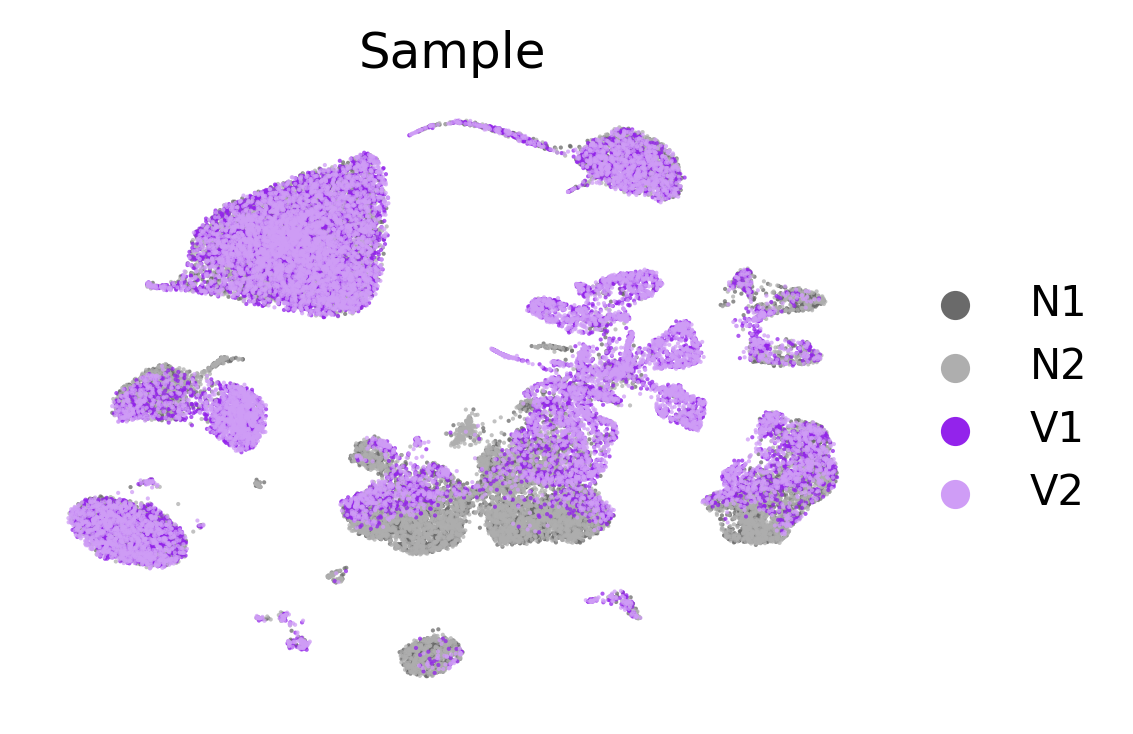

In [40]:
kwargs = {'alpha': 0.75}
plt.figure(figsize = (8,9))
um = plt.subplot(3,2,1)
um = sc.pl.umap(adata, color = ['Sample'], frameon = False,
                size=4, ax = um, layer = 'counts', vmin=-0.5, vmax=5,
                show=False, palette = gpcolors, **kwargs)
plt.savefig(directory + '/Figures/cellsGroupUMAP.png')

/var/folders/0d/m1rp2vsn40550y2btkrfwptr0000gn/T/ipykernel_12278/2683513435.py:11: RuntimeWarning: invalid value encountered in divide
  tcn = np.divide(typecount,np.sum(typecount,axis=0))


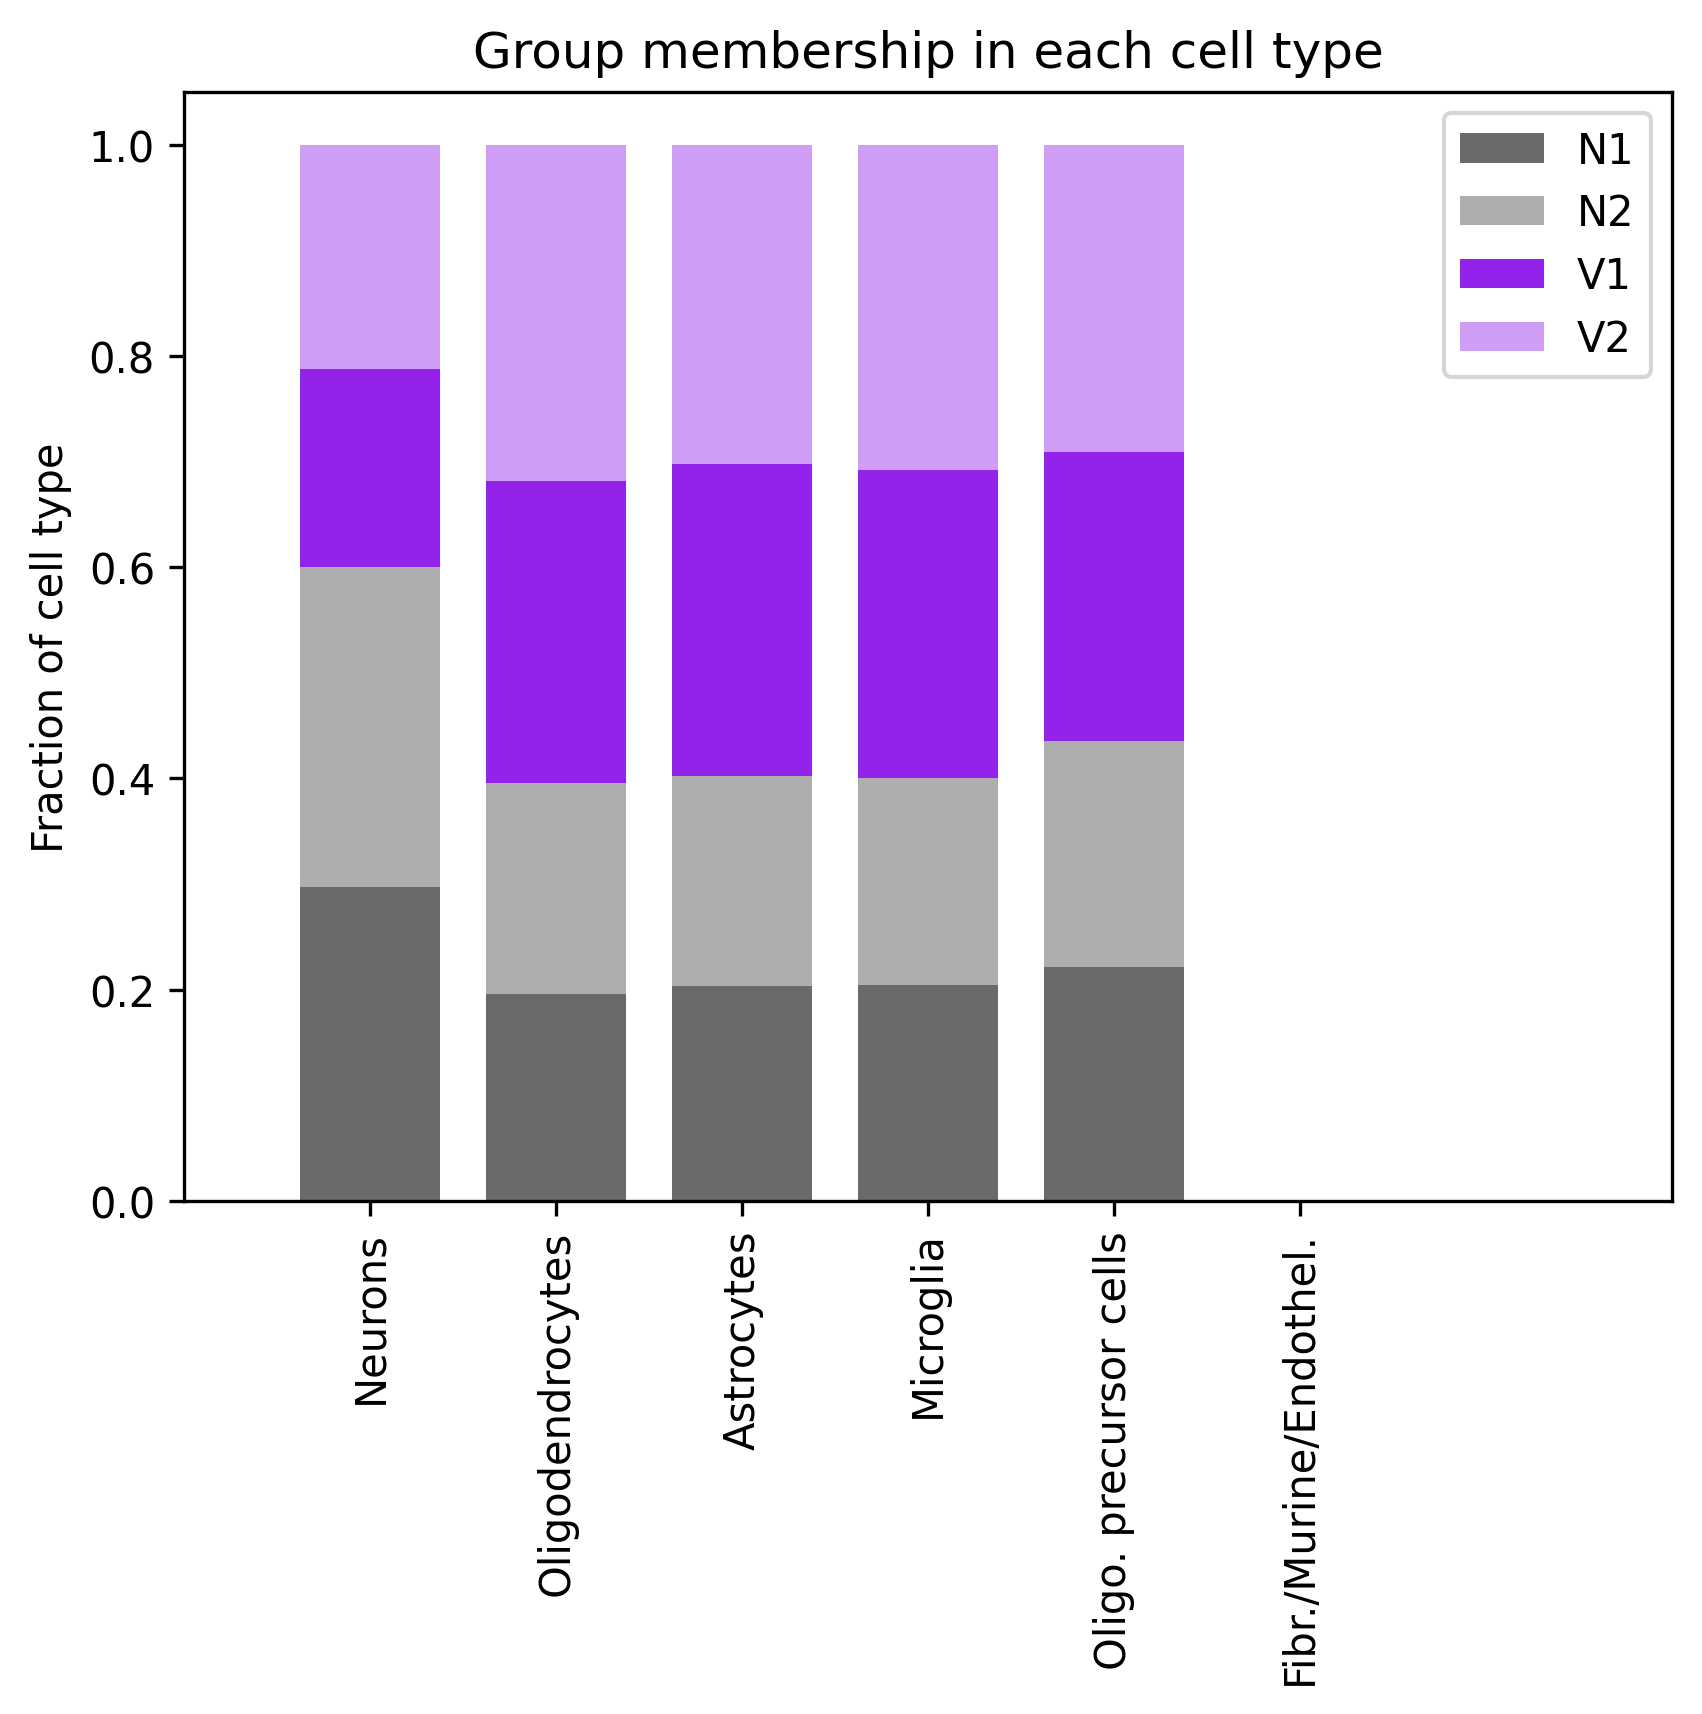

In [41]:
#plot fraction of each cell type from each batch
order = ['Neurons','Oligodendrocytes','Astrocytes','Microglia','Oligo. precursor cells',
         'Fibr./Murine/Endothel.']

groups = ['N1','N2','V1','V2']

typecount=np.zeros((len(groups),len(order)))
for g in range(0,len(groups)):   
    for t in range(0,len(order)):
        typecount[g,t]=np.sum((adata.obs['celltype']==order[t]) & (adata.obs['Sample']==groups[g]))                   

tcn = np.divide(typecount,np.sum(typecount,axis=0))

width = 0.75

fig, ax = plt.subplots()
bottom = np.zeros(6)

for g in range(0,len(groups)):
    p = ax.bar(order, tcn[g,:], width, label=groups[g], bottom=bottom, color=gpcolors[groups[g]])
    bottom += tcn[g,:]

plt.title('Group membership in each cell type')
ax.legend(loc="upper right")
plt.xlim((-1,7))
plt.xticks(rotation=90)
plt.ylabel('Fraction of cell type')
plt.show()

/Users/david/opt/anaconda3/envs/scvi-env/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/david/opt/anaconda3/envs/scvi-env/lib/python3.9/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/Users/david/opt/anaconda3/envs/scvi-env/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/david/opt/anaconda3/envs/scvi-env/lib/python3.9/site-pack

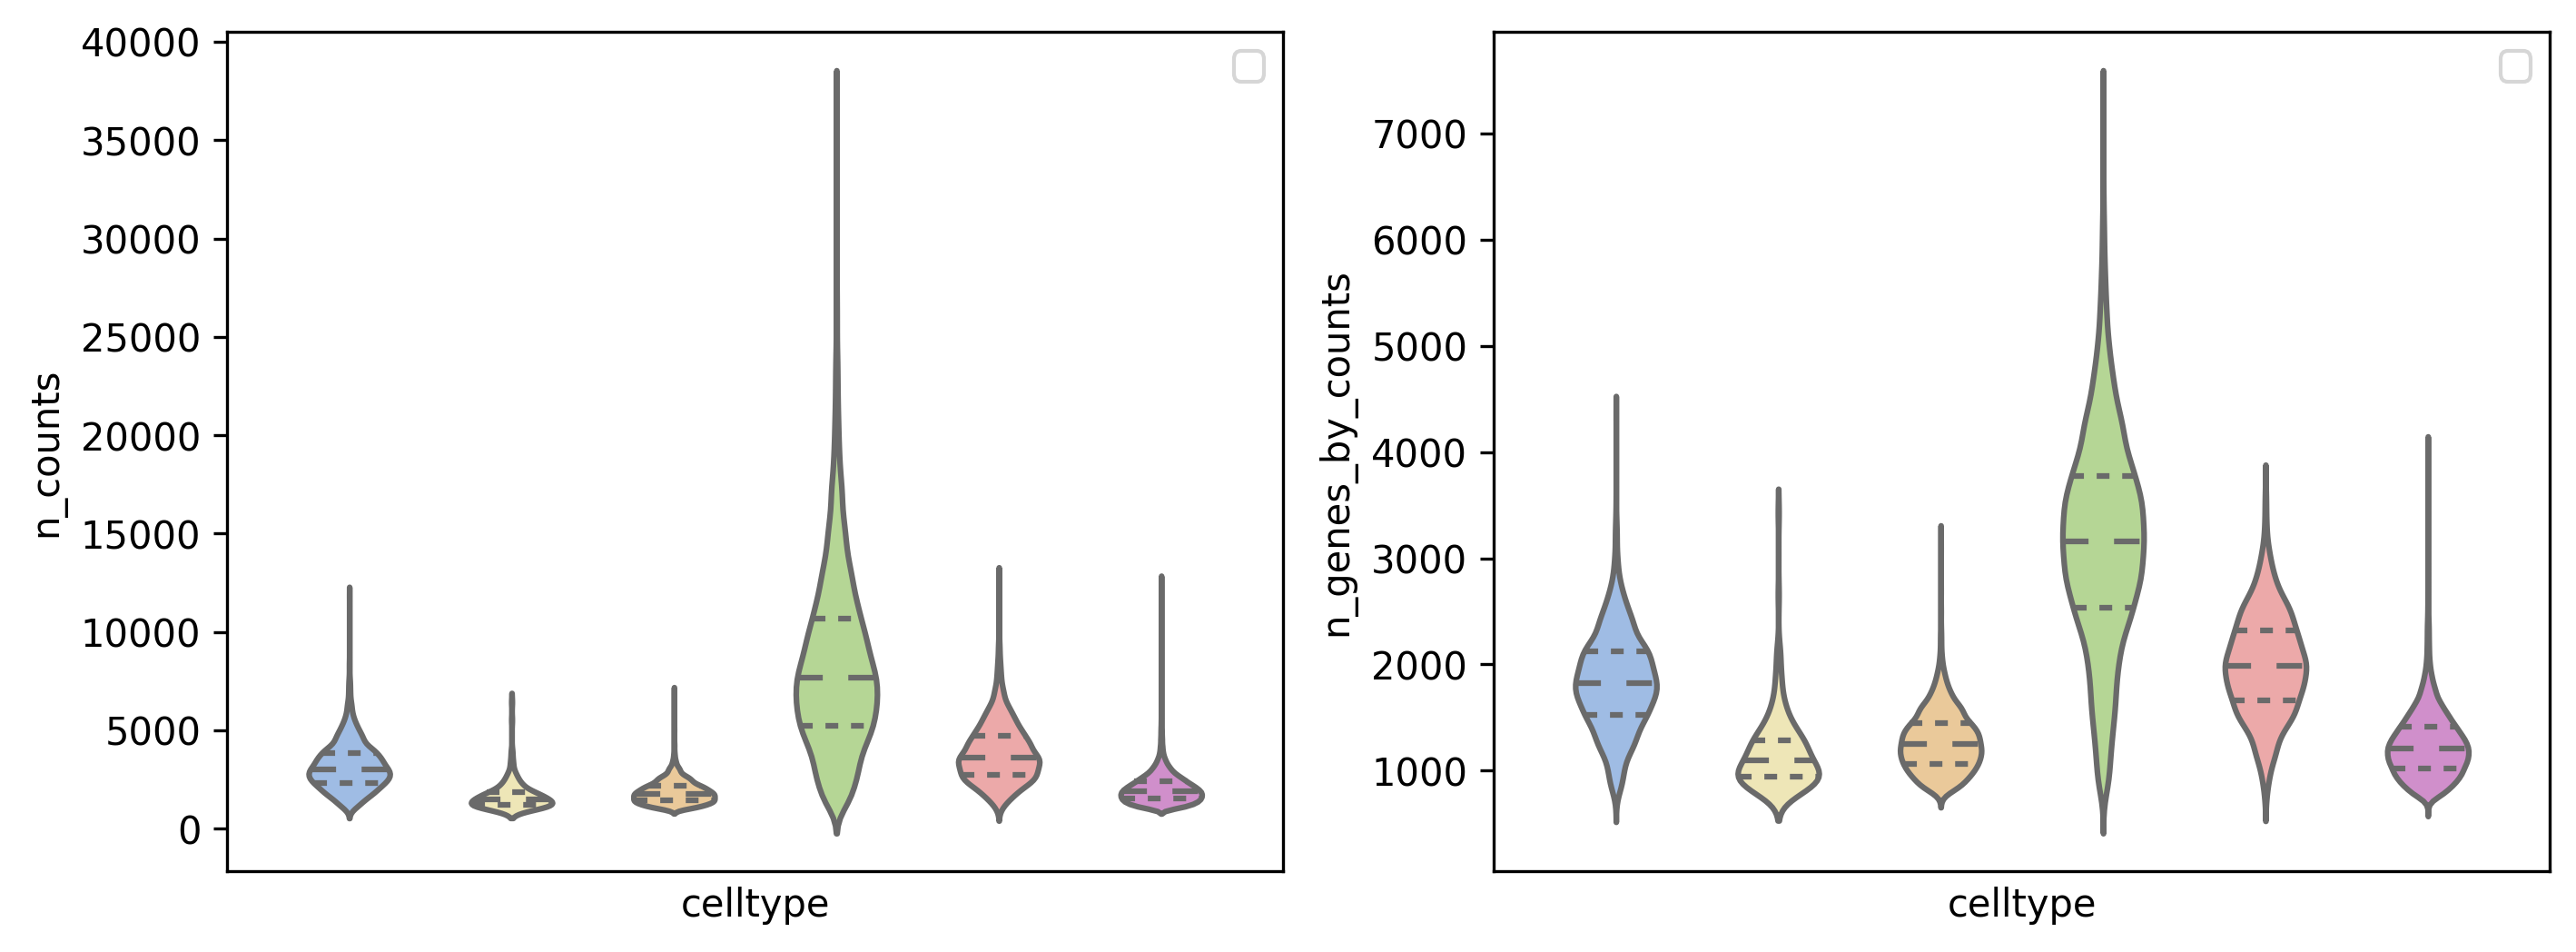

In [42]:
#plot quality metrics
plt.figure(figsize=(11,4))
plt.subplot(1,2,1)
sns.violinplot(adata.obs,x='celltype',y='n_counts',hue='celltype',split=False,inner='quart',palette=ctcolors, width=6)
plt.xlim((-4,9))
plt.xticks(())
plt.legend(())

plt.subplot(1,2,2)
sns.violinplot(adata.obs,x='celltype',y='n_genes_by_counts',hue='celltype',split=False,inner='quart',palette=ctcolors, width=6)
plt.xlim((-4,9))
plt.xticks(())
plt.legend(())
plt.savefig(directory + '/Figures/cellsQM.svg')

In [43]:
adata.write_h5ad(directory + '/combined.h5ad')

In [2]:
adata = sc.read_h5ad(directory + '/combined.h5ad')

In [44]:
adata = adata[adata.obs.celltype=='Neurons']
adata.X.shape

(20392, 23149)

In [ ]:
#prepare for Map My Cell

In [45]:
#function to create mappings for translating NCBI gene into Ensembl gene
def get_ensembl_mappings():                                   
    # Set up connection to server                                               
    server = biomart.BiomartServer('http://useast.ensembl.org/biomart')         
    mart = server.datasets['mmusculus_gene_ensembl']                            
                                                                                
    # List the types of data we want                                            
    attributes = ['mgi_symbol','ensembl_gene_id']
                                                                                
    # Get the mapping between the attributes                                    
    response = mart.search({'attributes': attributes})                          
    data = response.raw.data.decode('ascii')                                    
                                                                                
    ensembl_to_genesymbol = {}                                                  
    # Store the data in a dict                                                  
    for line in data.splitlines():                                              
        line = line.split('\t')                                                 
        gene_symbol = line[0]                                                   
        ensembl_gene = line[1]                                                  
        ensembl_to_genesymbol[gene_symbol] = ensembl_gene                      
                                                                                
    return ensembl_to_genesymbol

In [46]:
mappings = get_ensembl_mappings()

In [47]:
#get Ensembl names
varlist = adata.var.index.to_numpy()
varlistens = varlist.copy()
include = np.full(len(varlist),False)
gdb = list(mappings.keys())
for x in range(0,len(varlist)):
    if np.isin(varlist[x],gdb):
        varlistens[x]=mappings[varlist[x]]
        include[x]=True

In [48]:
#create smaller anndata with just ens gene and barcodes
adataS = ad.AnnData(adata[:,include].layers['counts'])
adataS.var.index=varlistens[include]
adataS.obs.index=adata.obs.index

In [49]:
adataS.write_h5ad(directory + '/neuronsMMC.h5ad')

In [53]:
#load in results from MMC
mmcdata = pd.read_csv(directory + '/mmc.csv', header=4, index_col=0)

In [54]:
adata.obs['class']=mmcdata['class_name'].astype('category')
adata.obs['subclass']=mmcdata['subclass_name'].astype('category')
adata.obs['supertype']=mmcdata['supertype_name'].astype('category')
adata.obs['cluster']=mmcdata['cluster_name'].astype('category')

/var/folders/0d/m1rp2vsn40550y2btkrfwptr0000gn/T/ipykernel_12278/967811297.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['class']=mmcdata['class_name'].astype('category')


In [55]:
adata

AnnData object with n_obs × n_vars = 20392 × 23149
    obs: 'Sample', 'n_counts', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'leiden', 'celltype', 'class', 'subclass', 'supertype', 'cluster'
    var: 'n_cells'
    uns: 'neighbors', 'umap', 'Sample_colors', 'leiden', 'leiden_colors', 'celltype_colors'
    obsm: 'X_scVI', 'X_umap'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

In [56]:
del(adata.obsm,adata.obsp,adata.uns,adata.obs['n_counts'],adata.obs['leiden'],adata.var['n_cells'])

In [57]:
adata.obs

,Sample,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,total_counts_ribo,pct_counts_ribo,celltype,class,subclass,supertype,cluster
N1:AAACCCAAGCGAATGC-1,N1,2390,4696.0,6.0,0.127768,8.0,0.170358,Neurons,09 CNU-LGE GABA,063 STR D1 Sema5a Gaba,0282 STR D1 Sema5a Gaba_2,0992 STR D1 Sema5a Gaba_2
N1:AAACCCACAGTCGCAC-1,N1,1306,2063.0,13.0,0.630150,8.0,0.387785,Neurons,09 CNU-LGE GABA,062 STR D2 Gaba,0275 STR D2 Gaba_2,0977 STR D2 Gaba_2
N1:AAACCCATCCTGGGAC-1,N1,1204,1842.0,137.0,7.437568,4.0,0.217155,Neurons,09 CNU-LGE GABA,061 STR D1 Gaba,0270 STR D1 Gaba_6,0959 STR D1 Gaba_6
N1:AAACCCATCGGTATGT-1,N1,1324,1941.0,14.0,0.721278,6.0,0.309119,Neurons,09 CNU-LGE GABA,062 STR D2 Gaba,0278 STR D2 Gaba_5,0984 STR D2 Gaba_5
N1:AAACGAAAGGGTGAAA-1,N1,2565,5236.0,12.0,0.229183,12.0,0.229183,Neurons,09 CNU-LGE GABA,061 STR D1 Gaba,0273 STR D1 Gaba_9,0964 STR D1 Gaba_9
...,...,...,...,...,...,...,...,...,...,...,...,...
V2:TTTGGTTAGATTACCC-1,V2,3846,11612.0,8.0,0.068894,17.0,0.146400,Neurons,09 CNU-LGE GABA,063 STR D1 Sema5a Gaba,0284 STR D1 Sema5a Gaba_4,1000 STR D1 Sema5a Gaba_4
V2:TTTGGTTAGTGGTCAG-1,V2,4245,11564.0,19.0,0.164303,16.0,0.138360,Neurons,08 CNU-MGE GABA,057 NDB-SI-MA-STRv Lhx8 Gaba,0251 NDB-SI-MA-STRv Lhx8 Gaba_8,0908 NDB-SI-MA-STRv Lhx8 Gaba_8
V2:TTTGTTGCAATGTTGC-1,V2,4364,11547.0,83.0,0.718801,10.0,0.086603,Neurons,11 CNU-HYa GABA,086 MPO-ADP Lhx8 Gaba,0404 MPO-ADP Lhx8 Gaba_3,1466 MPO-ADP Lhx8 Gaba_3
V2:TTTGTTGCACACCTGG-1,V2,4569,12514.0,51.0,0.407544,23.0,0.183794,Neurons,11 CNU-HYa GABA,086 MPO-ADP Lhx8 Gaba,0403 MPO-ADP Lhx8 Gaba_2,1462 MPO-ADP Lhx8 Gaba_2


In [58]:
adata.write_h5ad(directory + '/neurons.h5ad')